# Angle Recovery with GDM and Isomap

## Content

1. [Data Preparation](Read-Data)
2. [Geodesic Distance Matrix (GDM)](#Geodesic-Distance-Matrix)
3. [Isomap Embeddings](#Isomap)

## Read Data

Data used:
- Protein: 5a1a (symmetric protein)
- Projections: 5K
- Coverage: Half-sphere

![](figures/5a1a.pdb1-500.jpg)

In [1]:
import os
import h5py
import numpy as np
from time import time

import sys
sys.path.append("../..") 
from cryoem.plots import plot_angles_count, plot_euclidean_space, save_space_plot
from IPython.display import Image

In [2]:
PROTEIN="5j0n"#"5a1a"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000

In [3]:
# location of *.h5 files
data_dir = f"{ROOT_DIR}/data"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (116, 116) pixels
5000 sets of 3 ground truth angles of corresponding projection images


### True Angles

In [4]:
angles_true = np.array(data['Angles'])
angles_true.shape

(5000, 3)

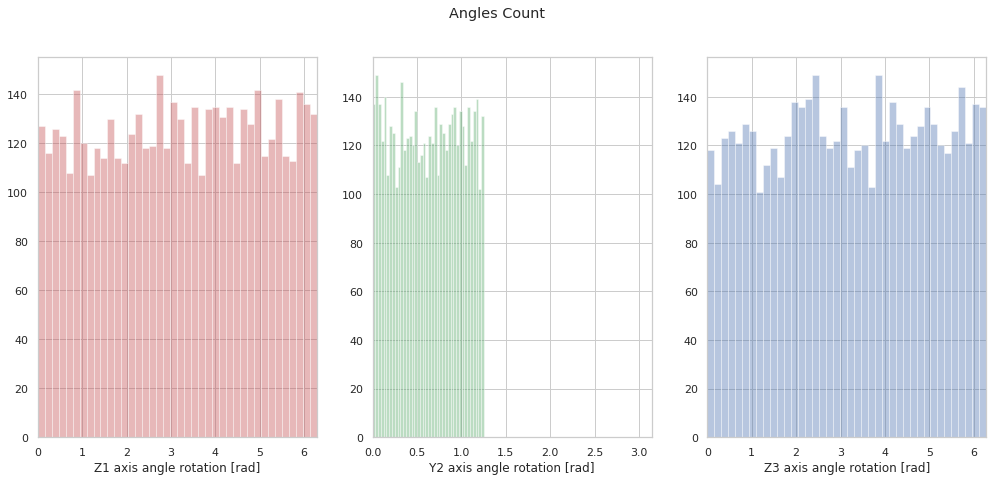

In [5]:
plot_angles_count(angles_true)

---

## Quaternion Distance Matrix

This is done using the kNN with geodesic distances between true angles. Later, when we start to use the real projections instead of true angles, we will be using the `projections` as input to kNN and the distance metric will be the one learned from the SiameseNN (`d_P`).

In [6]:
from cryoem.plots import plot_rays

In [7]:
plot_rays(angles_true, indices=range(10))

In [8]:
from pyquaternion import Quaternion

In [9]:
def euler2quaternion(angles):
    def _inner(a_z0, a_y, a_z1):
        q_z0 = Quaternion(axis=[0,0,1], angle=a_z0)
        q_y = Quaternion(axis=[0,1,0], angle=a_y)
        q_z1 = Quaternion(axis=[0,0,1], angle=a_z1)

        q = q_z0*q_y*q_z1
        return q #np.array([q.w, q.x, q.y, q.z])
    
    quaternions = []
    for a in angles:
        quaternions.append(_inner(a[0], a[1], a[2]))
    return np.array(quaternions)

In [10]:
quaternions = euler2quaternion(angles_true)
quaternions

array([Quaternion(-0.14754780530982708, 0.19085255370786888, 0.3973034383464813, -0.8854122914041245),
       Quaternion(-0.7529404376597125, -0.013344610575336716, -0.009315076547263794, -0.6578874129015633),
       Quaternion(-0.9406384128552512, 0.3305312744503097, 0.011654230647598574, -0.07624061764847434),
       ...,
       Quaternion(-0.5247594702720334, -0.0429334078869579, 0.11034879038635032, -0.8429753052772639),
       Quaternion(-0.25159425436295746, -0.06674806581655071, 0.580834949079571, -0.771281912668143),
       Quaternion(-0.982920727732691, 0.09105480438532815, -0.10982812215598242, 0.11624822224652459)],
      dtype=object)

In [11]:
def quaternions_coeffs(quaternions):
    coeffs = []
    for q in quaternions:
        coeffs.append(np.array([q.w, q.x, q.y, q.z]))
    return np.array(coeffs)

Plot $S^3$ hypersphere

In [12]:
import ipyvolume as ipv

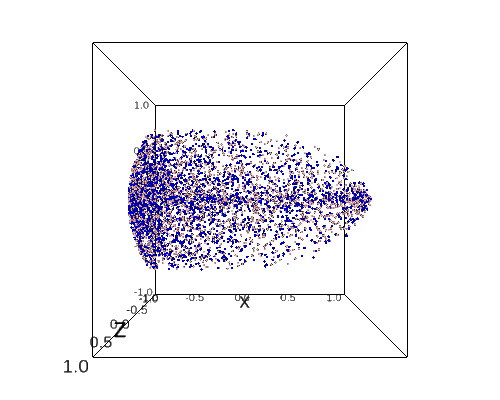

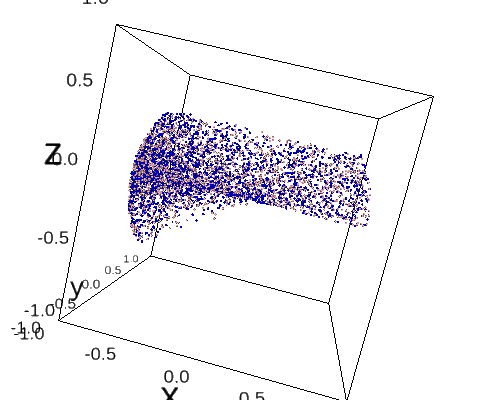

In [13]:
ipv.figure(width=500, height=400)

qcoeffs = quaternions_coeffs(quaternions)

pos_q0 = np.where(qcoeffs[:,3] >= 0)[0]
neg_q0 = np.where(qcoeffs[:,3] < 0)[0]
ipv.scatter(qcoeffs[pos_q0, 0], qcoeffs[pos_q0, 1], qcoeffs[pos_q0, 2], marker="sphere", color="blue", size=1)
ipv.scatter(qcoeffs[neg_q0, 0], qcoeffs[neg_q0, 1], qcoeffs[neg_q0, 2], marker="sphere", color="pink", size=1)

ipv.xlim(-1, 1)
ipv.ylim(-1, 1)
ipv.zlim(-1, 1)
ipv.show()

In [15]:
display(ipv.screenshot())

Output()

In [16]:
def d_p(a, b):
    return Quaternion.distance(a, b)   #absolute_distance(a, b)

In [17]:
d_p(quaternions[0], quaternions[1])

0.8129641022775128

In [18]:
start_time = time()

A = np.zeros((len(quaternions), len(quaternions)))

for i in range(len(quaternions)):
    for j in range(i, len(quaternions)):
        A[i, j] = A[j, i] = d_p(quaternions[i], quaternions[j])
        
print(f"--- {time() - start_time} seconds ---")

--- 801.9228429794312 seconds ---


In [19]:
A.shape

(5000, 5000)

In [20]:
# np.save(A, "data/quaternion_A.npy")

## Isomap

In [21]:
from sklearn.manifold import Isomap
from matplotlib import pyplot as plt
import ipyvolume as ipv

In [22]:
start_time = time()

embedding = Isomap(n_neighbors=500, n_components=6)
A_transformed = embedding.fit_transform(A)

print(f"--- {time() - start_time} seconds ---")

--- 216.91704630851746 seconds ---


In [23]:
A_transformed.shape

(5000, 6)

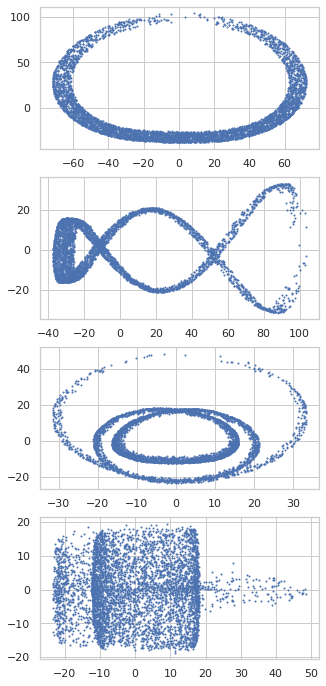

In [24]:
fig, ax = plt.subplots(4,1, figsize=(5,12))
ax[0].plot(A_transformed[:,0], A_transformed[:,1], marker="o", lw=0, markersize=1)
ax[1].plot(A_transformed[:,1], A_transformed[:,2], marker="o", lw=0, markersize=1)
ax[2].plot(A_transformed[:,2], A_transformed[:,3], marker="o", lw=0, markersize=1)
ax[3].plot(A_transformed[:,3], A_transformed[:,4], marker="o", lw=0, markersize=1)
plt.show()

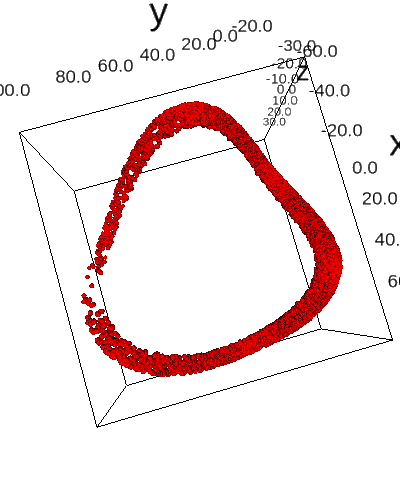

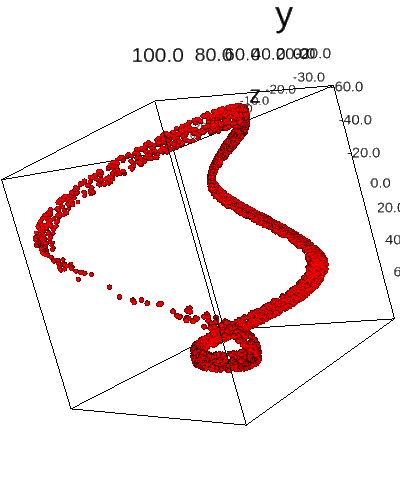

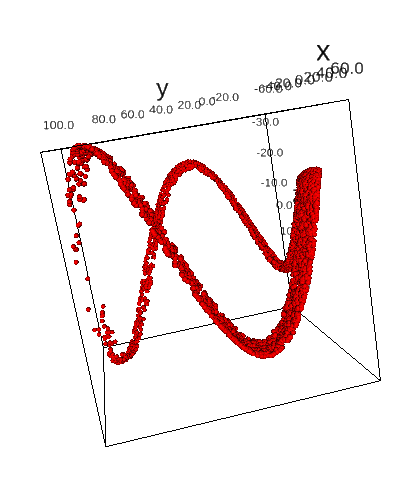

In [145]:
ipv.clear()
ipv.scatter(A_transformed[:,0], A_transformed[:,1], A_transformed[:,2], marker="sphere")
ipv.show()

In [167]:
display(ipv.screenshot())

Output()

In [85]:
def mat2quat(R):
    e0_sq = 1/4*(1+np.trace(R))
    e0 = np.sqrt(e0_sq)
    if e0_sq >0:
        e1 = 1/(4*e0)*(R[2,1]-R[1,2])
        e2 = 1/(4*e0)*(R[0,2]-R[2,0])
        e3 = 1/(4*e0)*(R[1,0]-R[0,1])
    else:
        e1_sq = -1/2*(R[1,1]+R[2,2])
        e1 = np.sqrt(e1_sq)
        if e1_sq > 0:
            e2 = R[0,1]/(2*e1)
            e3 = R[0,2]/(2*e1)
        else:
            e2_sq = 1/2*(1-R[2,2])
            e2 = np.sqrt(e2_sq)
            if e2_sq > 0:
                e3 = R[1,2]/(2*e2)
            else:
                e3 = 1
    return Quaternion(w=e0, x=e1, y=e2, z=e3).normalised

In [86]:
def f_GS(R):
    """6D to SO(3)"""
    # make 3x2 matrix
    a1 = R[:,0]
    a2 = R[:,1]

    b1 = a1/np.linalg.norm(a1)
    b2 = a2 - np.dot(b1,a2)*b1
    b2 = b2/np.linalg.norm(b2)
    b3 = np.cross(b1, b2)
    # ERROR: resulting matrix should be orthogonal!!!!!!!!!!!!!!!!!!
    return np.column_stack((b1, b2, b3)).astype(np.float32)

In [87]:
def g_GS(X):
    """SO(3) to 6D"""
    a1 = X[:,0]
    a2 = X[:,1]
    a3 = X[:,2]
    
    return np.column_stack((a1, a2)).astype(np.float32)

In [88]:
def f_q(q):
    # TODO: fix here!!!
    return q.normalised.rotation_matrix  #np.around(q.normalised.rotation_matrix, decimals=9)

In [89]:
def g_q(M):
    # TODO: fix here!!!!
    #return -Quaternion(matrix=M).normalised
    return mat2quat(M)

In [90]:
print("q =\n", quaternions[0])
M = f_q(quaternions[0])
print("M =\n", M)
q = g_q(M)
print("q =\n", q)

q =
 -0.148 +0.191i +0.397j -0.885k
M =
 [[-0.8836099  -0.10962853 -0.45520889]
 [ 0.41293403 -0.64075925 -0.64723494]
 [-0.22072389 -0.75987445  0.61145056]]
q =
 0.148 -0.191i -0.397j +0.885k


In [91]:
R = A_transformed[0].reshape((3,2))
print("R =\n", R)
X = f_GS(R)
print("X =\n", X)

print("Complains X is not orthogonal, but it is! Floating point problem")
X_tr = X.T  #np.around(X.T, decimals=6)
X_inv = np.linalg.inv(X)  #np.around(np.linalg.inv(X), decimals=6)
print("X.T =\n", X_tr)
print("X.inverse =\n", X_inv)
print(X_tr == X_inv)
print(np.allclose(np.dot(X, X.conj().transpose()), np.eye(3)))
print(np.dot(X, X.conj().transpose()))

q = g_q(X)
print(q)

R = g_GS(X)
print("R =\n", R)
X = f_GS(R)
print("X =\n", X)
# q = g_q(X)
# q

R =
 [[61.30281997  6.94479674]
 [17.66567153  8.19085143]
 [ 6.06272282  7.57070429]]
X =
 [[ 0.9565883  -0.25190893  0.14656301]
 [ 0.27566063  0.6188133  -0.7355823 ]
 [ 0.09460462  0.7440511   0.6613909 ]]
Complains X is not orthogonal, but it is! Floating point problem
X.T =
 [[ 0.9565883   0.27566063  0.09460462]
 [-0.25190893  0.6188133   0.7440511 ]
 [ 0.14656301 -0.7355823   0.6613909 ]]
X.inverse =
 [[ 0.95658827  0.27566063  0.09460461]
 [-0.25190893  0.6188133   0.7440511 ]
 [ 0.14656301 -0.73558235  0.6613909 ]]
[[False  True False]
 [ True  True  True]
 [ True False  True]]
False
[[ 1.0000000e+00  9.9566906e-09 -3.4398209e-09]
 [ 9.9566906e-09  9.9999994e-01  4.0743238e-08]
 [-3.4398209e-09  4.0743238e-08  1.0000000e+00]]
0.900 +0.411i +0.014j +0.147k
R =
 [[ 0.9565883  -0.25190893]
 [ 0.27566063  0.6188133 ]
 [ 0.09460462  0.7440511 ]]
X =
 [[ 0.9565883  -0.25190893  0.14656301]
 [ 0.27566063  0.6188133  -0.7355823 ]
 [ 0.09460462  0.7440511   0.66139096]]


In [92]:
(f_GS(g_GS(X)) == X).all()

True

In [93]:
(g_GS(f_GS(R)) == R).all()

True

---

This is expected 6D elemenents from true quaternion

In [94]:
q = quaternions[0]
q

Quaternion(-0.14754780530982708, 0.19085255370786888, 0.3973034383464813, -0.8854122914041245)

In [95]:
X = f_q(q)
R = g_GS(X)
R

array([[-0.8836099 , -0.10962853],
       [ 0.41293404, -0.6407592 ],
       [-0.2207239 , -0.75987446]], dtype=float32)

We expect the embedding to be R matrix (3x2)

In [96]:
A_transformed[0].reshape((3,2))

array([[61.30281997,  6.94479674],
       [17.66567153,  8.19085143],
       [ 6.06272282,  7.57070429]])

In [97]:
R = A_transformed[0].reshape((3,2))
X = f_GS(R)
q = g_q(X)
q

Quaternion(0.8995544150225051, 0.4112128501612207, 0.014440035255441606, 0.14661968373184303)

In [98]:
from scipy.spatial.transform import Rotation as R

r = R.from_quat([q.x, q.y, q.z, q.w])
r.as_euler("zyz"), angles_true[0]

(array([ 1.69726571,  0.84812457, -1.37412435]),
 array([4.09944284, 0.91290385, 4.99508373]))

In [99]:
# TODO do for all

In [116]:
from scipy.spatial.transform import Rotation as R

def emb2angle(emb):
    def _inner(e):
        R_mat = e.reshape((3,2))
        X = f_GS(R_mat)
        q = g_q(X)
        r = R.from_quat([q.x, q.y, q.z, q.w])
        a = r.as_euler("zyz")
        return a
#         try:
#             q = g_q(X)
#             r = R.from_quat([q.x, q.y, q.z, q.w])
#             a = r.as_euler("zyz")
#             return a
#         except ValueError:
#             return None
    
    angles = []
    indices = []
    for i, e in enumerate(emb):
        a = _inner(e)
        if a is not None:
            angles.append(a)
            indices.append(i)
    return np.array(angles), indices

In [117]:
angles_emb, indices = emb2angle(A_transformed)

In [118]:
angles_emb.shape

(5000, 3)

In [119]:
at = np.take(angles_true, indices, axis=0)
at[0], angles_emb[0]

(array([4.09944284, 0.91290385, 4.99508373]),
 array([ 1.69726571,  0.84812457, -1.37412435]))

In [120]:
at[-1], angles_emb[-1]

(array([0.57449347, 0.28630611, 5.4732492 ]),
 array([-2.28567964,  0.63453128, -1.39470321]))

In [121]:
plot_euclidean_space(np.take(angles_true, indices, axis=0))

In [131]:
angles_emb

array([[ 1.69726571,  0.84812457, -1.37412435],
       [-1.40293955,  3.04554829,  1.38928835],
       [ 3.11365334,  1.7348946 , -1.22032113],
       ...,
       [-1.49721595,  0.59614363,  1.45134436],
       [-1.16532022,  0.11715644,  1.35554041],
       [-2.28567964,  0.63453128, -1.39470321]])

In [136]:
ipv.clear()
ipv.plot(angles_emb[:,0], angles_emb[:,1], angles_emb[:,1], marker="o", lw=0)
ipv.show()

In [108]:
display(ipv.screenshot())

Output()

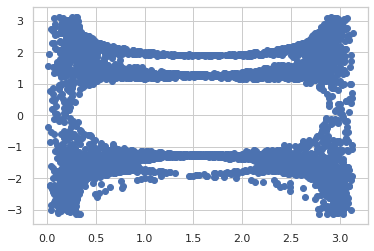

In [130]:
plt.plot(angles_emb[:,1], angles_emb[:,2], marker="o", lw=0)

In [246]:
def logQall(qs):
    def logQ(q):
        if q[3]<0:
            q =-q
        theta = np.arccos(q[3])
        n = np.array([q[0], q[1], q[2]])
        norm = n / np.linalg.norm(n)
        return norm * theta
    logs = np.zeros((qs.shape[0], qs.shape[1]-1))
    for i, q in enumerate(qs):
        logs[i] = logQ(q)
    return logs

In [152]:
logs = logQall(quaternions)

In [155]:
ipv.figure(width=500, height=400)
ipv.scatter(logs[:, 0], logs[:, 1], logs[:, 2], marker="sphere", color="blue", size=1)
# ipv.xlim(-80, 80)
# ipv.ylim(-80, 80)
# ipv.zlim(-80, 80)
ipv.show()

In [150]:
ipv.figure(width=500, height=400)
ipv.scatter(A_transformed[:, 0], A_transformed[:, 1], A_transformed[:, 2], marker="sphere", color="blue", size=1)
ipv.xlim(-80, 80)
ipv.ylim(-80, 80)
ipv.zlim(-80, 80)
ipv.show()

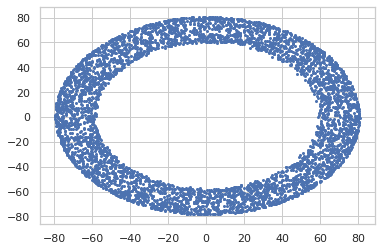

In [140]:
plt.plot(A_transformed[:,0], A_transformed[:,1], lw=0, marker="o", markersize=2)

In [134]:
ipv.figure(width=500, height=400)
ipv.scatter(quaternions[:, 0], quaternions[:, 1], quaternions[:, 2], marker="sphere", color="blue", size=1)
# ipv.xlim(-1, 1)
# ipv.ylim(-1, 1)
# ipv.zlim(-1, 1)
ipv.show()

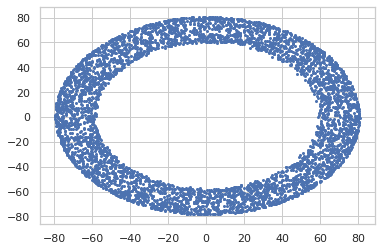

In [135]:
plt.plot(A_transformed[:,0], A_transformed[:,1], lw=0, marker="o", markersize=2)

In [92]:
ipv.figure(width=500, height=400)
ipv.scatter(quaternions[:, 0], quaternions[:, 1], quaternions[:, 2], marker="sphere", color="blue", size=1)
# ipv.xlim(-1, 1)
# ipv.ylim(-1, 1)
# ipv.zlim(-1, 1)
ipv.show()

In [96]:
from scipy.spatial.transform import Rotation as R

In [97]:
r = R.from_quat(A_transformed, normalized=False)

In [98]:
angles_predicted = r.as_euler('zyz', degrees=False)
angles_predicted.shape

(5000, 3)

In [99]:
angles

array([[2.74129289, 0.84906729, 5.48198312],
       [0.05198987, 0.52439503, 0.5559678 ],
       [5.01955447, 0.17657386, 1.26418297],
       ...,
       [5.3902725 , 1.07968313, 5.74111375],
       [1.17188032, 0.65006988, 2.25601305],
       [2.54509695, 0.82837041, 2.37254411]])

In [100]:
angles_predicted

array([[-2.62453116,  2.56996272,  1.0607892 ],
       [-1.74351199,  2.64195661, -1.63473982],
       [ 2.04985773,  2.57070681, -2.90225341],
       ...,
       [ 2.59280713,  2.58481977,  0.49195832],
       [ 3.11645782,  2.5352882 , -2.43099979],
       [ 2.87770807,  2.55441461,  0.66185342]])

In [101]:
# plot_euclidean_space(angles_predicted)

In [102]:
plot_euclidean_space(angles_predicted)

In [105]:
rm = RotationMatrix(angles_predicted)[:,:3]

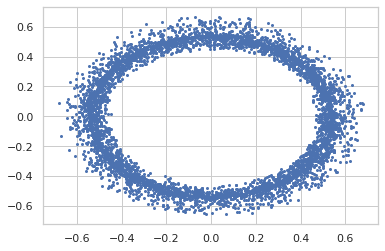

In [107]:
plt.plot(rm[:,0], rm[:,1], lw=0, marker="o", markersize=2)

#### Scale Embedding

In [17]:
radius = np.max(A_transformed)

In [18]:
A_transformed_norm = A_transformed/radius
translate_z_axis = -1 - np.min(A_transformed_norm[:,2])

In [19]:
A_transformed_norm[:,2] = A_transformed_norm[:,2]+translate_z_axis

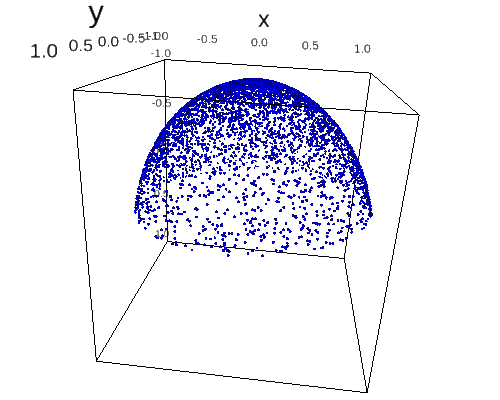

In [20]:
ipv.figure(width=500, height=400)
ipv.scatter(A_transformed_norm[:, 0], A_transformed_norm[:, 1], A_transformed_norm[:, 2], marker="sphere", color="blue", size=1)
ipv.xlim(-1, 1)
ipv.ylim(-1, 1)
ipv.zlim(-1, 1)
ipv.show()

In [21]:
filename = f"figures/{PROTEIN}_Isomap_random_all"
save_space_plot(filename)

Image(filename=f"{filename}.png",width=300, height=300)

Output()

In [22]:
angles_true_rotated = RotationMatrix(angles_true)[:,:3]

##### Flip

In [23]:
for i, f in enumerate(A_transformed_norm):
    A_transformed_norm[i] = [f[0], -f[1], -f[2]]

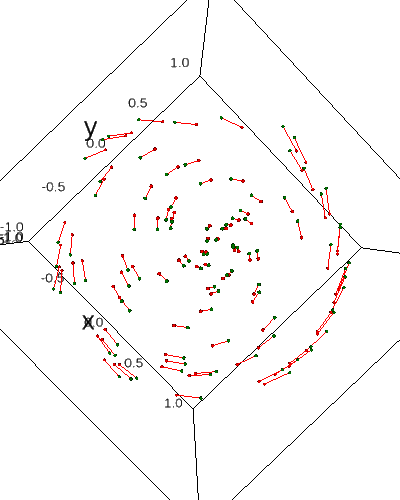

In [24]:
ipv.clear()
selected = range(100)
aps = np.take(A_transformed_norm, selected, axis=0)
ats = np.take(angles_true_rotated, selected, axis=0)
ipv.scatter(ats[:,0], ats[:,1], ats[:,2], marker="sphere", color="green", size=1)
ipv.scatter(aps[:,0], aps[:,1], aps[:,2], marker="sphere", color="red", size=1)
for i in selected:
    connection0 = [ats[i,0], aps[i,0]]
    connection1 = [ats[i,1], aps[i,1]]
    connection2 = [ats[i,2], aps[i,2]]
    ipv.plot(connection0, connection1, connection2,color="red", lynestyle="--")
ipv.xlim(-1, 1);ipv.ylim(-1,1);ipv.zlim(-1, 1)
ipv.show()

In [25]:
filename = f"figures/{PROTEIN}_Isomap_random"
save_space_plot(filename)

Image(filename=f"{filename}.png",width=300, height=300)

Output()

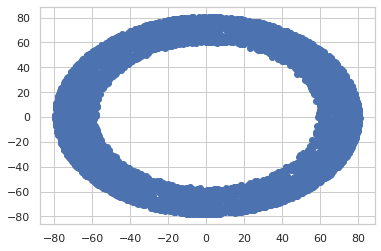

In [45]:
plt.plot(A_transformed[:,0], A_transformed[:,1], lw=0, marker="o")

In [ ]:
def rotationMat2angles(rot_mat):
    beta = np.arccos(a[2])
    gamma = np.arcsin(a[1]/np.sin(beta))
    # TODO: missing the 3rd angle!!!!

---